##Downloading dataset from kaggel & Connect to Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install kaggle

# from google.colab import files
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Replace 'iarunava/cell-images-for-detecting-malaria' with the actual dataset URL
# !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content/drive/MyDrive/datasets

# # Unzip the downloaded dataset (if it's a zip file)
# !unzip /content/drive/MyDrive/datasets/cell-images-for-detecting-malaria.zip -d /content/drive/MyDrive/datasets



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Importing the tools</h1>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtBase, EfficientNetV2S
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


<h1> image processing</h1>


In [6]:
# Define data directory
data_dir ="/content/drive/MyDrive/datasets/cell_images"

# Function to collect image paths
def collect_image_paths(data_dir, categories):
    data = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):  # Ensure the path exists
            filepaths = [os.path.join(category_path, fname) for fname in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, fname))]
            for file in filepaths:
                data.append((file, category))
    return data

# Directories for images
categories = ['Parasitized', 'Uninfected']  # Classes

# Collect image paths and labels
data = collect_image_paths(data_dir, categories)

# Create DataFrame from data
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Convert labels to numeric
df['label_numeric'] = df['label'].map({'Uninfected': 0, 'Parasitized': 1})

# Sample 500 images from each class to balance the dataset
df_parasitized = df[df['label'] == 'Parasitized'].sample(n=200, random_state=42) #edit this if you want have spesific sample numbers
df_uninfected = df[df['label'] == 'Uninfected'].sample(n=200, random_state=42) #edit this if you want have spesific sample numbers
df_balanced = df.reset_index(drop=True)

# Combine the two balanced subsets
df_balanced = pd.concat([df_parasitized, df_uninfected]).reset_index(drop=True)

# Split dataset into train (80%), validation (12%), and test (8%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.2, random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.4, random_state=42)  # 40% of temp = 8% of total

# Print sizes of each set
print("Total data size:", len(df_balanced))
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

# Print label ratios for each dataset
def print_label_ratios(dataset, name):
    print(f"\nLabel distribution in {name} set:")
    label_counts = dataset['label'].value_counts(normalize=True)
    print(label_counts)

print_label_ratios(train_df, "train")
print_label_ratios(val_df, "validation")
print_label_ratios(test_df, "test")


Total data size: 400
Train set size: 320
Validation set size: 48
Test set size: 32

Label distribution in train set:
label
Uninfected     0.5125
Parasitized    0.4875
Name: proportion, dtype: float64

Label distribution in validation set:
label
Parasitized    0.604167
Uninfected     0.395833
Name: proportion, dtype: float64

Label distribution in test set:
label
Uninfected     0.53125
Parasitized    0.46875
Name: proportion, dtype: float64


In [ ]:
label_counts = test_df['label'].value_counts()

# Cetak jumlah label
print("Jumlah label 'Parasitized':", label_counts.get('Parasitized', 0))
print("Jumlah label 'Uninfected':", label_counts.get('Uninfected', 0))



Jumlah label 'Parasitized': 1134
Jumlah label 'Uninfected': 1071


##Plotting Data distribution by pie chart

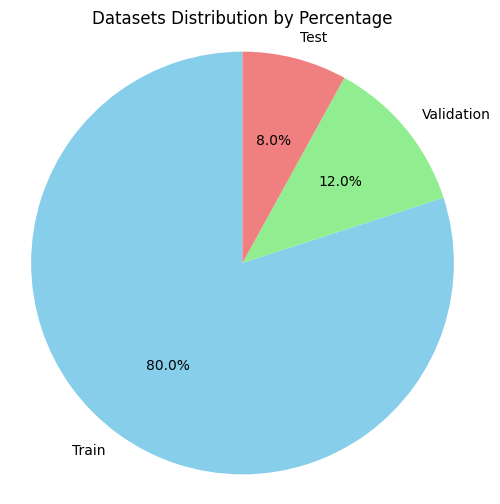

In [ ]:
# Menghitung jumlah gambar pada setiap DataFrame
train_size = len(train_df)
valid_size = len(val_df)
test_size = len(test_df)

# Menghitung total dan persentase
total_size = train_size + valid_size + test_size
train_pct = (train_size / total_size) * 100
valid_pct = (valid_size / total_size) * 100
test_pct = (test_size / total_size) * 100

# Data untuk plotting
labels = ['Train', 'Validation', 'Test']
sizes = [train_pct, valid_pct, test_pct]
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Plot distribusi data dalam bentuk pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Datasets Distribution by Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Plotting contoh data dalam train

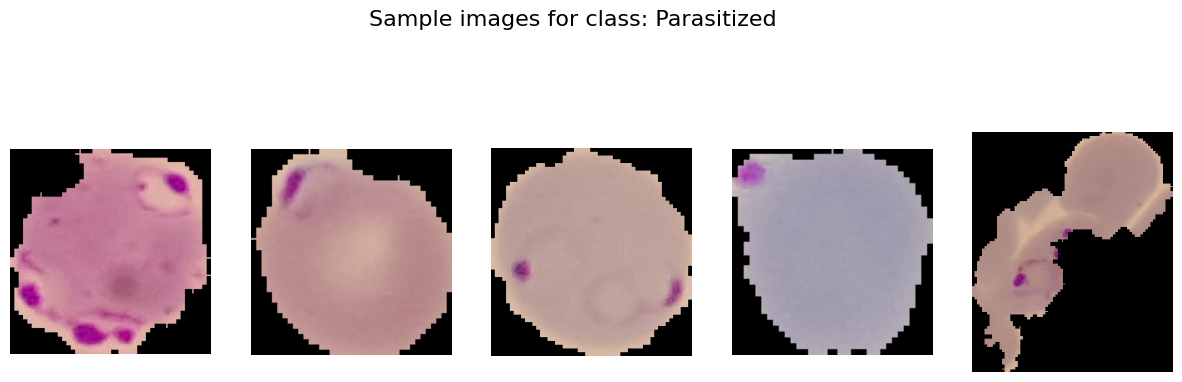

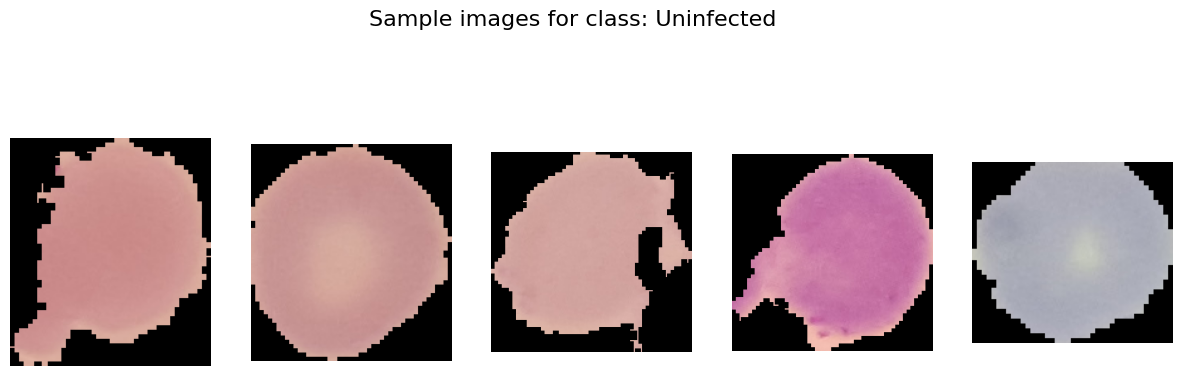

In [ ]:


# Function to plot sample images from each class
def plot_sample_images(dataset, label, num_samples=5):
    # Filter the dataset for the specified label
    sample_df = dataset[dataset['label'] == label].sample(num_samples, random_state=42)

    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_df['file_path']):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample images for class: {label}', fontsize=16)
    plt.show()

# Plot 5 sample images from each class in the training set
plot_sample_images(train_df, 'Parasitized', num_samples=5)
plot_sample_images(train_df, 'Uninfected', num_samples=5)


<h1>Data Augmentation</h1>

In [11]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalisasi gambar
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # brightness_range=[0.9, 1.1],
    # fill_mode='nearest'
)

img_size = 224

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalisasi untuk validation set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)   # Normalisasi untuk test set

# Data generators from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Print class distribution
print(np.bincount(train_generator.classes))

Found 320 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
[156 164]


:<h1>ConvNeXtbase Model minimum LR </h1>

In [12]:
# Load ConvNeXtBase with pre-trained weights
base_model = ConvNeXtBase(
    include_top=False,
    weights= 'imagenet',
    input_shape=(224, 224, 3)
)
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((1, 1)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Callbacks
checkpoint = ModelCheckpoint('new/best_model.keras',
monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,936,449 (343.08 MB)

 Trainable params: 89,936,449 (343.08 MB)

 Non-trainable params: 0 (0.00 B)

<h1>Train Minimum LR</h1>

In [13]:
# Train the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint],
    verbose=1
)

import pickle
with open('new/history_minimum.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4734 - loss: 0.6942
Epoch 1: val_accuracy improved from -inf to 0.60417, saving model to new/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 306s 8s/step - accuracy: 0.4739 - loss: 0.6942 - val_accuracy: 0.6042 - val_loss: 0.6845
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5404 - loss: 0.6911
Epoch 2: val_accuracy did not improve from 0.60417
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 741ms/step - accuracy: 0.5393 - loss: 0.6914 - val_accuracy: 0.3958 - val_loss: 0.6971
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5058 - loss: 0.6954
Epoch 3: val_accuracy did not improve from 0.60417
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 658ms/step - accuracy: 0.5047 - loss: 0.6955 - val_accuracy: 0.3958 - val_loss: 0.7004
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4964 - loss: 0.6935
Epoch 4: val_accuracy did not improve from 0.60417
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - accuracy: 0.4975 - loss: 0.6934

<h1>Confusion Matrix on minimum LR</h1>

207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step


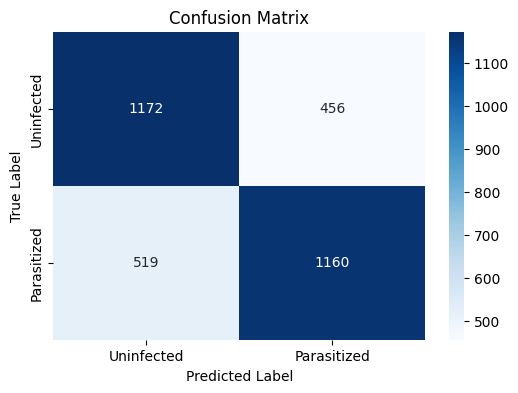

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.69      0.72      0.71      1628
 Parasitized       0.72      0.69      0.70      1679

    accuracy                           0.71      3307
   macro avg       0.71      0.71      0.71      3307
weighted avg       0.71      0.71      0.71      3307



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/best_model_minimum_.keras")

# Step 1: Predict labels on test data
y_pred_probs = model.predict(valid_generator)  # Predict probabilities
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Get true labels
y_true = valid_generator.classes  # Actual labels

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'], zero_division=0))


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/best_model_minimum.keras")

model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 1435s 10s/step - accuracy: 0.7090 - loss: 0.5549


[0.5639946460723877, 0.7011337876319885]

<h1>Grafik Accuracy & Val_accuracy Minimum LR</h1>

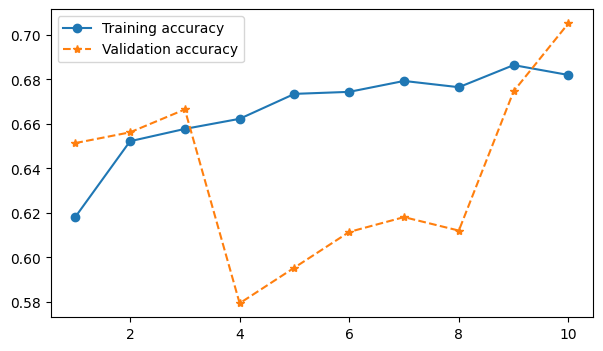

In [ ]:
import matplotlib.pyplot as plt
import pickle

# Load history (if needed)
with open('history_minimum.pkl', 'rb') as f:
    history = pickle.load(f)

epochs = 10

plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()



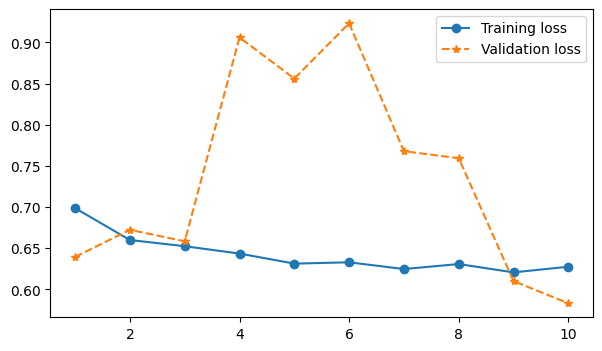

In [ ]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

ConvNeXtBase Maksimum LR

In [ ]:
# Load ConvNeXtBase with pre-trained weights
model_base = ConvNeXtBase(
    include_top=False,
    weights= 'imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model initially
model_base.trainable = False

# Add new layers on top of the base model
x = model_base.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  # Menambahkan dropout untuk regularisasi
x = Flatten() (x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid untuk binary classification

# Define the full model
model = Model(inputs=model_base.input, outputs=predictions)


# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML-Modelsbest_model_maksimum.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_prestem_no… │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stem        │ (None, 56, 56, 128)    │          6,528 │ convnext_base_prestem… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │          6,400 │ convnext_base_stem[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            256 │ convnext_base_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 512)    │         66,048 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 512)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │         65,664 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            128 │ convnext_base_stage_0… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 128)    │              0 │ convnext_base_stem[0]… │
│                           │                        │                │ convnext_base_stage_0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │          6,400 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            256 │ convnext_base_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0

 Total params: 87,616,641 (334.23 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

Tranining Maksimum LR

In [ ]:
# Train the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint],
)

import pickle
with open('history_maksimum.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5846 - loss: 1.7596
Epoch 1: val_accuracy improved from -inf to 0.59964, saving model to /content/drive/MyDrive/ML-Modelsbest_model_maksimum.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 5835s 4s/step - accuracy: 0.5846 - loss: 1.7597 - val_accuracy: 0.5996 - val_loss: 2.0653
Epoch 2/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6115 - loss: 1.7552
Epoch 2: val_accuracy did not improve from 0.59964
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 317s 229ms/step - accuracy: 0.6115 - loss: 1.7552 - val_accuracy: 0.5634 - val_loss: 2.5815
Epoch 3/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6243 - loss: 1.7124
Epoch 3: val_accuracy improved from 0.59964 to 0.65195, saving model to /content/drive/MyDrive/ML-Modelsbest_model_maksimum.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 319s 230ms/step - accuracy: 0.6243 - loss: 1.7125 - val_accuracy: 0.6520 - val_loss: 1.5193
Epoch 4/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0

<h1>Confusion Matrix on Maksimum LR</h1>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/best_model_maksimnum.keras")

# Step 1: Predict labels on test data
y_pred_probs = model.predict(test_generator)  # Predict probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Use argmax for multi-class
# If binary classification, you can keep the original threshold method:
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Get true labels
y_true = test_generator.classes  # Actual labels

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'], zero_division=0))


ValueError: Layer "dense_7" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(16, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3963>, <KerasTensor shape=(16, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3964>]

<h1>Grafik Accuracy & Val_accuracy</h1>

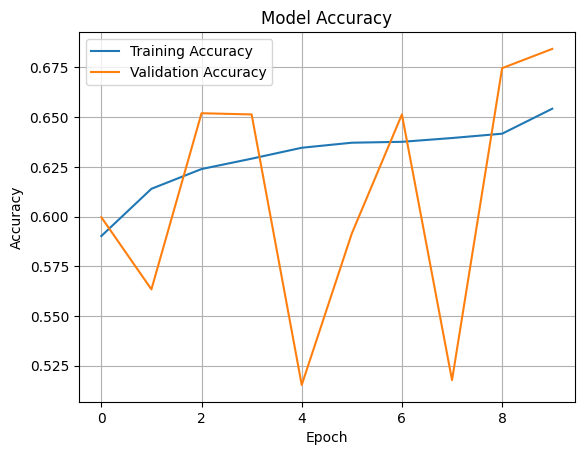

In [ ]:
# Load the saved history
with open('/content/history_maksimum.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

# Plot the accuracy and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


<h1>EfficientNetV2S</h1>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S

# Load the EfficientNetV2S model with pre-trained weights (ImageNet) and define the input shape
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

# Freeze the first 20 layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Ensure the rest of the layers are trainable
for layer in base_model.layers[20:]:
    layer.trainable = True

# Create a Sequential model
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Define the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/ML-Models/best_model_minimum_EfficientNetV2S.keras',
                                                monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 384, 384, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 192, 24)   │            648 │ rescaling_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 192, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 192, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 192, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 192, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 192, 192, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 192, 192, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 192, 192, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 192, 192, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 192, 192, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 192, 192, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 192, 192, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 22,233,697 (84.81 MB)

 Trainable params: 21,960,089 (83.77 MB)

 Non-trainable params: 273,608 (1.04 MB)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ML-Models/best_model_minimum_EfficientNetV2S.keras')

# Define the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/ML-Models/best_model_minimum_EfficientNetV2S.keras',
                                                monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint],
)

import pickle
with open('/content/drive/MyDrive/ML-Models/history_minimum_EfficientNetV2S.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

ValueError: Exception encountered when calling Conv2D.call().

[1mKernel shape must have the same length as input, but received kernel of shape (3, 3, (None, 12, 12, 1280), 64) and input of shape [(None, 12, 12, 1280)].[0m

Arguments received by Conv2D.call():
  • args=(['<KerasTensor shape=(None, 12, 12, 1280), dtype=float32, sparse=False, name=keras_tensor_1611>'],)
  • kwargs=<class 'inspect._empty'>

Confusion Matriks EfficientNEtV2S

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/ML-Models/best_model_minimum_EfficientNetV2S.keras')

# Step 1: Predict labels on test data
y_pred_probs = model.predict(test_generator)  # Predict probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Use argmax for multi-class
# If binary classification, you can keep the original threshold method:
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Get true labels
y_true = test_generator.classes  # Actual labels

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'], zero_division=0))


ValueError: Exception encountered when calling Conv2D.call().

[1mKernel shape must have the same length as input, but received kernel of shape (3, 3, (None, 12, 12, 1280), 64) and input of shape [(None, 12, 12, 1280)].[0m

Arguments received by Conv2D.call():
  • args=(['<KerasTensor shape=(None, 12, 12, 1280), dtype=float32, sparse=False, name=keras_tensor_4363>'],)
  • kwargs=<class 'inspect._empty'>

## Maxima LR EfficientNetV2S


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S

# Load the EfficientNetV2S model with pre-trained weights (ImageNet) and define the input shape
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

# Freeze the first 20 layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Ensure the rest of the layers are trainable
for layer in base_model.layers[20:]:
    layer.trainable = True

# Create a Sequential model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Define the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ML-Models/best_model_maksimal_EfficientNetV2S.keras",
                                                monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/MyDrive/ML-Models/best_model_maksimal_EfficientNetV2S.keras')

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint],
    verbose = 1
)

import pickle
with open('/content/drive/MyDrive/ML-Models/history_maksimum_EfficientNetV2S.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8836 - loss: 0.3138
Epoch 1: val_accuracy did not improve from 0.95833
200/200 ━━━━━━━━━━━━━━━━━━━━ 2271s 11s/step - accuracy: 0.8836 - loss: 0.3137 - val_accuracy: 0.9479 - val_loss: 0.2357
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8963 - loss: 0.3028
Epoch 2: val_accuracy did not improve from 0.95833
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 474ms/step - accuracy: 0.8963 - loss: 0.3028 - val_accuracy: 0.9396 - val_loss: 0.1789
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9079 - loss: 0.2621
Epoch 3: val_accuracy did not improve from 0.95833
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 471ms/step - accuracy: 0.9078 - loss: 0.2621 - val_accuracy: 0.9083 - val_loss: 0.2389
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9086 - loss: 0.2539
Epoch 4: val_accuracy did not improve from 0.95833
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.9086 - loss: 0.2539 - val_accuracy: 0.9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/ML-Models/best_model_maksimal_EfficientNetV2S.keras')

# Step 1: Predict labels on test data
y_pred_probs = model.predict(test_generator)  # Predict probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Use argmax for multi-class
# If binary classification, you can keep the original threshold method:
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Get true labels
y_true = test_generator.classes  # Actual labels

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'], zero_division=0))


ValueError: Layer "dense_1" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 12, 12, 1280), dtype=float32, sparse=False, name=keras_tensor_1094>, <KerasTensor shape=(None, 12, 12, 1280), dtype=float32, sparse=False, name=keras_tensor_1095>]

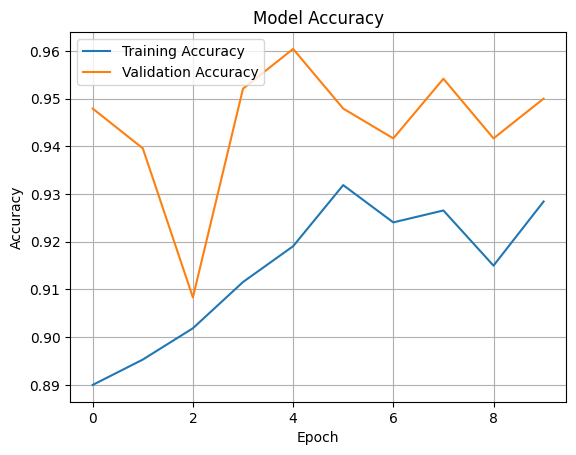

In [ ]:
# Load the saved history
with open('/content/drive/MyDrive/ML-Models/history_maksimum_EfficientNetV2S.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

# Plot the accuracy and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


##Grafik hasil traning dari semua arsitektur dan learning rate

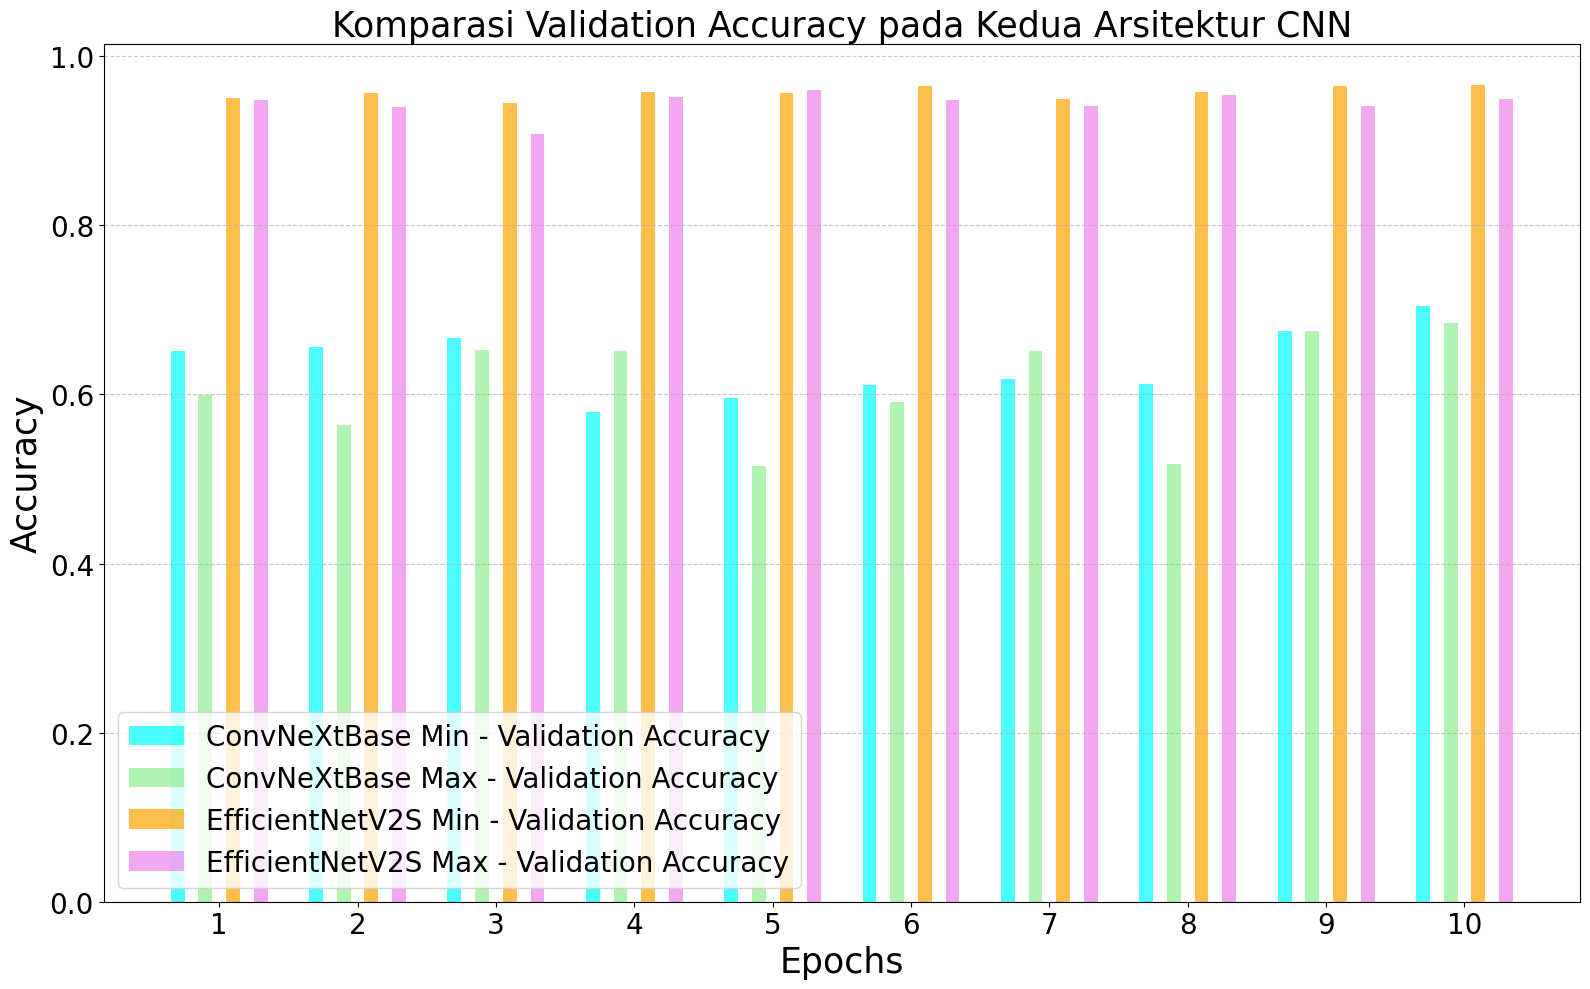

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Redefine the data for ConvNeXtBase and EfficientNetV2S
epochs = np.arange(1, 11)

convnext_min_acc = [0.6001, 0.6462, 0.6586, 0.6661, 0.6753, 0.6761, 0.6792, 0.6784, 0.6812, 0.6823]
convnext_min_val_acc = [0.6513, 0.6562, 0.6664, 0.5794, 0.5954, 0.6114, 0.6181, 0.612, 0.6746, 0.7051]

convnext_max_acc = [0.5846, 0.6115, 0.6243, 0.6254, 0.6353, 0.638, 0.642, 0.6378, 0.6398, 0.6542]
convnext_max_val_acc = [0.5996, 0.5634, 0.652, 0.6513, 0.5153, 0.5915, 0.6513, 0.5177, 0.6746, 0.6843]

efficient_min_acc = [0.8932, 0.9191, 0.9106, 0.9226, 0.9289, 0.9431, 0.9418, 0.9444, 0.9294, 0.9344]
efficient_min_val_acc = [0.9504, 0.9562, 0.9444, 0.9577, 0.9568, 0.9643, 0.9492, 0.9577, 0.9649, 0.9658]

efficient_max_acc = [0.8836, 0.8963, 0.9106, 0.9086, 0.9192, 0.9379, 0.9284, 0.9259, 0.9077, 0.9329]
efficient_max_val_acc = [0.9479, 0.9396, 0.9083, 0.9521, 0.9604, 0.9479, 0.9417, 0.9542, 0.9417, 0.95]

# Combining all data into one graph for comparison
fig, ax = plt.subplots(figsize=(16, 10))

# Plot for ConvNeXtBase Minimum Learning Rate
# ax.bar(epochs - 0.4, convnext_min_acc, width=0.1, label='ConvNeXtBase Min - Accuracy', color='blue', alpha=0.7)
ax.bar(epochs - 0.3, convnext_min_val_acc, width=0.1, label='ConvNeXtBase Min - Validation Accuracy', color='cyan', alpha=0.7)

# Plot for ConvNeXtBase Maximum Learning Rate
# ax.bar(epochs - 0.2, convnext_max_acc, width=0.1, label='ConvNeXtBase Max - Accuracy', color='green', alpha=0.7)
ax.bar(epochs - 0.1, convnext_max_val_acc, width=0.1, label='ConvNeXtBase Max - Validation Accuracy', color='lightgreen', alpha=0.7)

# Plot for EfficientNetV2S Minimum Learning Rate
# ax.bar(epochs, efficient_min_acc, width=0.1, label='EfficientNetV2S Min - Accuracy', color='red', alpha=0.7)
ax.bar(epochs + 0.1, efficient_min_val_acc, width=0.1, label='EfficientNetV2S Min - Validation Accuracy', color='orange', alpha=0.7)

# Plot for EfficientNetV2S Maximum Learning Rate
# ax.bar(epochs + 0.2, efficient_max_acc, width=0.1, label='EfficientNetV2S Max - Accuracy', color='purple', alpha=0.7)
ax.bar(epochs + 0.3, efficient_max_val_acc, width=0.1, label='EfficientNetV2S Max - Validation Accuracy', color='violet', alpha=0.7)

# Customizing the graph
ax.set_xlabel('Epochs', fontsize=25)
ax.set_ylabel('Accuracy', fontsize=25)
ax.set_title('Komparasi Validation Accuracy pada Kedua Arsitektur CNN', fontsize=25)
ax.set_xticks(epochs)
ax.tick_params(axis='x', labelsize=20)  # Atur ukuran font ticks pada sumbu x
ax.tick_params(axis='y', labelsize=20)  # Atur ukuran font ticks pada sumbu y
ax.legend(loc='lower left', fontsize=20)  # Atur ukuran font legend
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

plt.savefig("grafik.png", dpi=300)

